El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score , mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import numpy as np
import re


In [2]:
# %pip install -U --user scikit-learn

In [3]:
# df = pd.read_csv('/datasets/car_data.csv')

In [4]:
df = pd.read_csv('D:/Tripleten/datasets/car_data.csv')

In [5]:
# # BORRADOR , NO MANTENER

# df = df.sample(1000)

In [6]:
df.sample(4)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
36424,13/03/2016 13:46,1300,small,1999,manual,60,polo,150000,9,petrol,volkswagen,no,13/03/2016 00:00,0,28779,13/03/2016 13:46
128530,23/03/2016 15:49,7450,sedan,2008,manual,170,a3,150000,8,gasoline,audi,no,23/03/2016 00:00,0,90489,23/03/2016 15:49
83966,03/04/2016 15:54,2200,small,2000,manual,103,145,90000,12,petrol,alfa_romeo,no,03/04/2016 00:00,0,86368,03/04/2016 15:54
11892,15/03/2016 13:52,750,NaN,2016,manual,88,3_reihe,150000,5,petrol,mazda,NaN,15/03/2016 00:00,0,87600,06/04/2016 03:16


Renombrado columnas para mantener formato Snake_Case en el código.

In [7]:
cols = df.columns
snake_case_cols = []

for col in cols:
    snake_case_col = '_'.join(re.findall(r'[A-Z][a-z0-9]*', col)).lower()
    snake_case_cols.append(snake_case_col)

# print(snake_case_cols)
df.columns = snake_case_cols

Obteniendo información general

In [8]:
df.sample(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
289372,25/03/2016 18:45,4900,sedan,1986,auto,223,other,150000,6,petrol,mercedes_benz,no,25/03/2016 00:00,0,45897,07/04/2016 00:17
24704,08/03/2016 17:37,1299,wagon,1994,manual,174,NaN,150000,5,petrol,volkswagen,no,08/03/2016 00:00,0,74427,28/03/2016 23:16
40402,14/03/2016 11:50,19500,bus,2011,manual,102,transporter,90000,4,gasoline,volkswagen,no,14/03/2016 00:00,0,65428,07/04/2016 01:46
261010,10/03/2016 20:52,2800,sedan,2002,auto,131,mondeo,150000,11,gasoline,ford,no,10/03/2016 00:00,0,87719,25/03/2016 10:17
179928,15/03/2016 12:57,350,coupe,1999,manual,0,punto,150000,9,petrol,fiat,yes,15/03/2016 00:00,0,76149,17/03/2016 07:46


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Resaltando columnas con valores nulos

In [10]:
null_values = df.isna().sum()
null_rows= df.shape[0] - df.dropna().shape[0]

null_values = null_values[null_values>0]


print(f'Null values by column:')
print(null_values, end='\n\n')
print(f'Total null rows: {null_rows}')

Null values by column:
vehicle_type    37490
gearbox         19833
model           19705
fuel_type       32895
not_repaired    71154
dtype: int64

Total null rows: 108555


Observando si tenemos valores duplicados

In [11]:
duplicated_rows = df.duplicated()
duplicated_rows.sum()

262

Examinando manualmente un caso para verificar coherencia

In [12]:
df[(df['date_crawled'] == '21/03/2016 19:06') & (df['price']== 5999)]
# df.query("date_crawled == '21/03/2016 19:06' and price == 5999")

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
183,21/03/2016 19:06,5999,small,2009,manual,80,polo,125000,5,petrol,volkswagen,no,21/03/2016 00:00,0,65529,05/04/2016 20:47
14266,21/03/2016 19:06,5999,small,2009,manual,80,polo,125000,5,petrol,volkswagen,no,21/03/2016 00:00,0,65529,05/04/2016 20:47


Observaciones:

- Elementos con clasificaciones Dtype erroneos (price, not_repaired, date_crawled, last_seen)
- Elementos nulos para las columnas (vehicle_type, gearbox, model, fuel_type, not_repaired)
- 262 elementos duplicados.

Se reasignaran los tipos de valor date_crawled y last_seen al formato datetime64, se evitará reasignar los tipos de valor de price y not_repaired debido a sus valores nulos

In [13]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%d/%m/%Y %H:%M')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%d/%m/%Y %H:%M')

In [14]:
print(df['date_crawled'].dt.year.unique() == df['last_seen'].dt.year.unique())
# print(df['date_crawled'].dt.month.sort_values().unique() == df['last_seen'].dt.month.sort_values().unique())

[ True]


Los datos pertenecen al 2016 y las columnas date_crawled y last seen tiene los mismo resultados a nivel año y mes

Procedemos a eliminar los valores duplicados

In [15]:
df = df.drop_duplicates().reset_index(drop=True)

Crearé una función que me permita analizar de una manera visuallos elementos únicos que se encuentran dentro de mis columnas, para verificar si existen datos erroneos o extraños.



In [16]:
def analyze(db):
    obj = db.select_dtypes(include='object').columns
    int = db.select_dtypes(include='int').columns
    
    print('Analisis de elementos Object')
    for i in obj:

        print(f'Elementos de la columna {i}')
        print(db[i].sort_values().unique(), end='\n\n')

    for i in int:

        print(f'Elementos de la columna {i}')
        print(db[i].sort_values().unique(), end='\n\n')



In [17]:
analyze(df)

Analisis de elementos Object
Elementos de la columna vehicle_type
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

Elementos de la columna gearbox
['auto' 'manual' nan]

Elementos de la columna model
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'el

In [18]:
def chart_prev(df):
    fig, axes =plt.subplots(ncols=4,nrows=4,figsize=[12,12])

    for ax, column in zip(axes.flatten(), df.columns):
        ax.hist(df[column].dropna(), bins=10, color='g')
        ax.grid(True)
        ax.set_title(column)

    plt.tight_layout()
    plt.show()
    

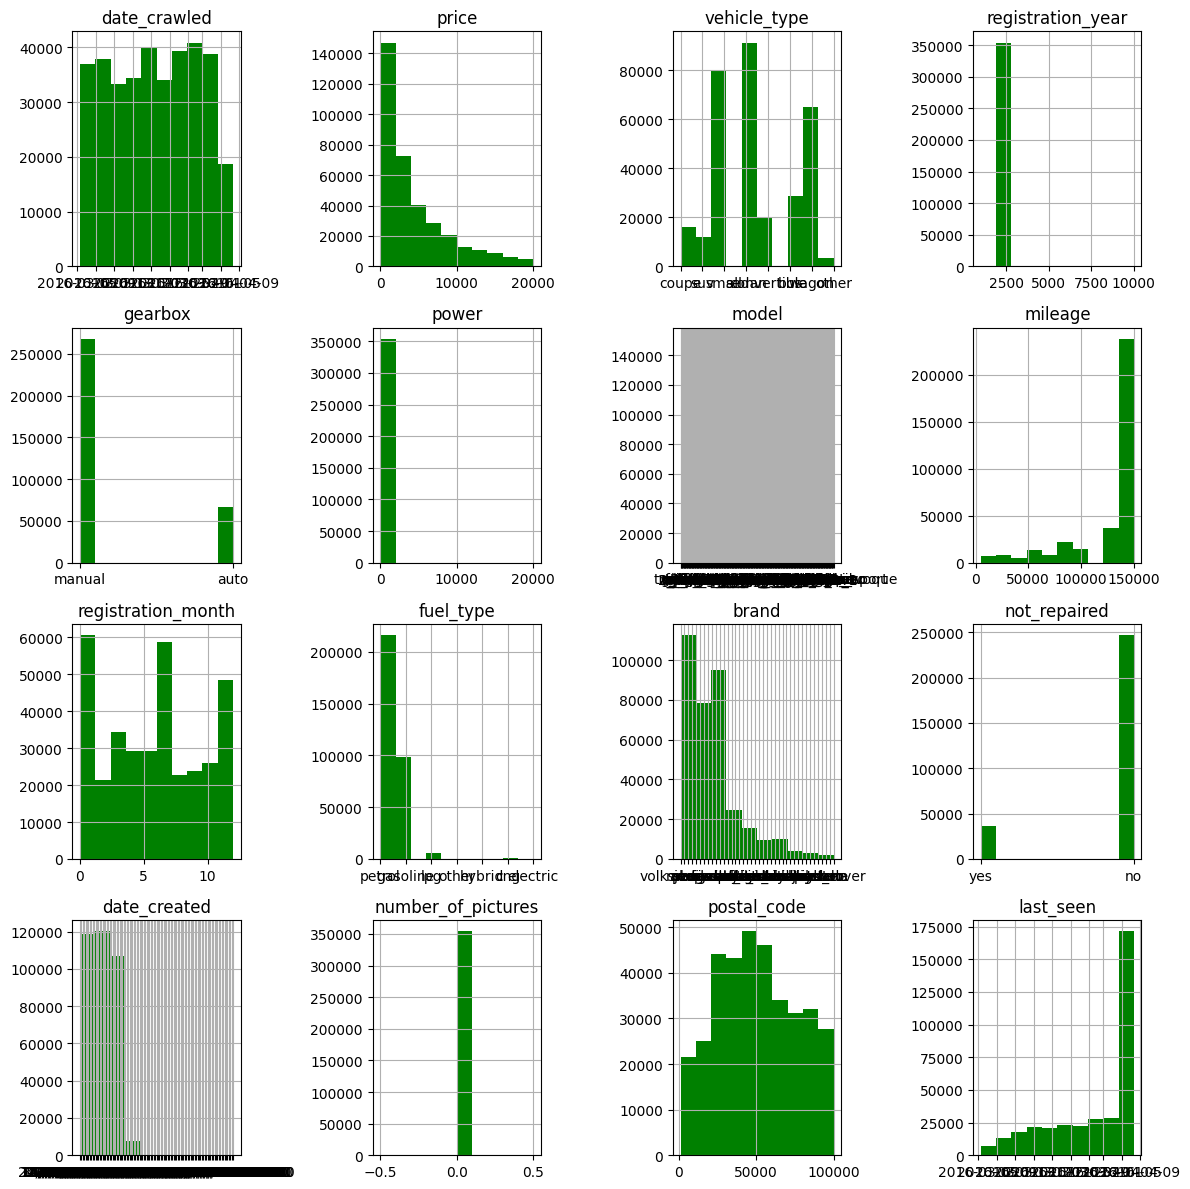

In [19]:
chart_prev(df)


### Observaciones


Al momento nos encontramos con las siguientes situaciones:

Elementos nulos para las columnas:
- vehicle_type
- gearbox 
- model
- fuel_type
- not_repaired

A su vez, hemos identificado incongruencias en los datos registrados para las siguientes columnas: 

- `price`: En los valores de precio puedo observar valores de muy bajos que pueden ser considerados `sesgos de información.`
- `registration year` : se pueden observar ver valores superiores al año actual y valores por debajo de 1886 (cuando se creó el primer vehículo), existen muchos `datos con sesgo`.
- `power` la medición esta en caballos de vapor. El primer vehiculo creado tenía una fuerza de CV de 0.75, por lo que es incongruente ver valores de 0 en la base de datos, en su contraparte, el vehículo con mayor velocidad de CV regitrada para 2020 fue de 1800 CV, por lo que `tenemos incongruencias` en los datos cuyos valores superan los a 10,000 CV. 

De un total de 16 columnas, 8 columnas se encuentran sesgadas

### Sesgo de 'price'

`- Existen precios de vehículos por debajo de los 600 dolares.`

Para poder ejecutar un análisis mas profundo es necesario identificar que pudo haber pasado con los datos, una suposición sería que la base se descargo de una plataforma en línea donde los usuarios pueden decidir el precio final de su vehículo, algunos usuarios podrían optar por colocar precios irreales para llamar la atención de los compradores.

Con el fin de alimentar nuestro modelo de una mejor manera, será necesario reclasificar o excluir los precios menores a 600 dolares. Este umbral se ha obtenido de la busqueda de los precios minimos y maximos para la venta de vehiculos en europa de los sitios
- www.coches.com,
- www.milanuncios.com

Si realizaramos un filtro de precios encontrariamos 46,313 filas afectadas que representan el 13.07% del total del dataset

### Sesgo de 'registration_year'
`- Se pueden observar ver valores superiores al año actual y valores por debajo de 1886 (antes del primer automovil creado).`

Siguiendo las fuentes antes mencionadas, podemos ver vehículos ofertados con fecha de registro desde 1980, mantendremos este umbral en nuestro dataset, por otra parte el registro muestra vehiculos con fecha de registro mayor a 2016, fecha en la que se descargaron estos datos. Por lo que datos posteriores no deberían de considerarse para este estudio.

Considerando la depuración del umbral mínimo y máximo, sería necesario depurar 17,978 filas representando un 5.07% del total del dataset.

### Sesgo de 'power'
`- Valores incongruentes en los CV, con valores inferiores a 60 y superiores a 500 en nuestra base de datos.`

Para la seccion de power tenemos como entrada que el primer vehiculo construido tenía una potencia de Caballos de Vapor (CV) de 0.75. 
De acuerdo con las paginas antes mencionadas, los vehiculos pueden tener una potencia entre 60 y 400 cv


Se obtuvieron muestras al azar los vehiculos de la base de datos con registro mayor a 400cv y ningúno clasifico con mas de 250 cv reales, por lo que limitaremos la búsqueda a 300 cv
Si manejamos los umbrales de 60,300 tendríamos un total de 67,268  datos por de purar representando un 18.99% del dataset.


### Sesgo de 'mileage'
`- Existen vehiculos con registro de salida del año en curso y con 150,000 km registrados (datos incongruentes).`

En promedio, los vehiculos generarn un kilometraje de 15,000 a 27,000 kms por año, para minimizar los datos afectados, se excluiran los autos con un kilometraje mayor a 150,000 para añós posteriores a 2011. (27 kms por añó).
19102 filas que corresponden a un 5.39 del dataset


### Primera conclusión

El dataset descargado presenta bastantes datos sesgados e incongruentes, si bien hemos establecido la hipótesis de que la base se descargo de una plataforma en línea donde los usuarios pueden decidir el precio final de su vehículo no podemos asegurar que sea correcta, sin embargo el enfoque principal del de este proyecto se basa en entrenar un modelo de predicción, por lo que será necesario excluir estos datos para tener una base de mejor calidad.

In [20]:
# Excluyendo valores price
recalibrate_df= df.copy()

In [21]:
recalibrate_df= recalibrate_df.query('price>=600')
recalibrate_df = recalibrate_df.query(' 1980 < registration_year < 2017')
recalibrate_df = recalibrate_df.query('60 <=power <=300')
recalibrate_df = recalibrate_df.query('~(registration_year>=2012 and mileage >= 150000)')

In [22]:
loss_data = (1 - (recalibrate_df.shape[0] / df.shape[0])) *100
print(f'Se ha depurado un {loss_data:.2f} de la data original')

Se ha depurado un 30.42 de la data original


In [23]:
recalibrate_df.shape

(246395, 16)

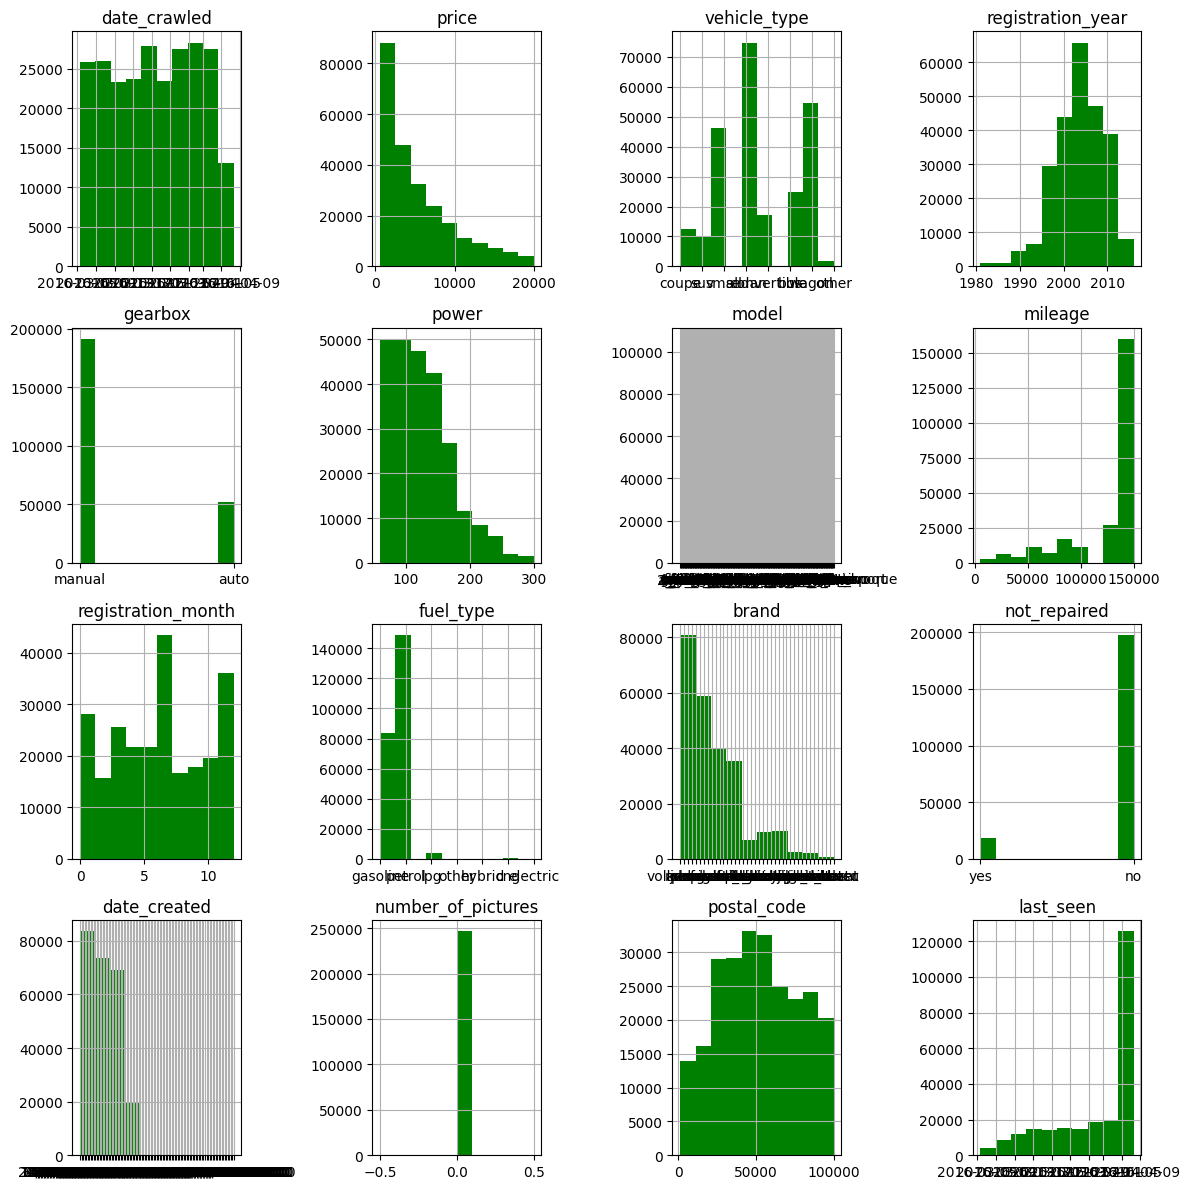

In [24]:
chart_prev(recalibrate_df)

Las columnas de power y de registration year ahora tienen coherencia, el kilometraje sigue estando alto para autos con valores de recorrido mayor a 150,000, de acuerdo con la información externa, esta puede entrar en el umbral de 27,000 kms por año.

### Valores nuloss

Para la manipulación de los valores nulos, se han analizado las siguientes opciones:
- Eliminación de filas o columnas con valores nulos
- Imputación de valores nulos
`- Uso de modelos de imputación`
- Codificación de valores nulos

Optaré por el uso de modelos de imputación

Para poder realizar el OHE previo al modelo de imputación, es necesario excluir algunas columnas para evitar la saturación de información y evitar exceder los límites de las capacidades del computador. Para ello, será necesario excluir también las columnas 'date_crawled', 'date_created, 'number_of_pictures y'last_seen'

La siguiente base se usará para usar los modelos de predicción, al mantener los mismos indices, puedo obtener las columnas faltantes de recalibrate_df y realizar la prediccion.

Dado que tengo elementos categóricos, estos los pasaré a numericos para ser manipulados por el modelo

Se crea una prueba de recalibrate_df para poder codificar un borrador.

In [25]:
# exportar recalibrate
recalibrate_df.to_csv('recalibrate',index=False)

In [24]:
# Borrador
# recalibrate = recalibrate_df.sample(100)

In [25]:
def OHE(df):
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(df)
    output_names = encoder.get_feature_names_out(df.columns)
    df_codified = pd.DataFrame(encoded_data.toarray(), columns=output_names, index= df.index)
    return df_codified, encoder

In [26]:
def inverse_OHE(encoded_df, encoder):
     # Realizar la inversión de la codificación one-hot
    inverse_data = encoder.inverse_transform(encoded_df)

    return inverse_data

In [27]:
def r_forests(X_train,X_test,y_train):
    param_grid = {
        'n_estimators': [10, 50, 100],  # Número de árboles en el bosque
        'max_depth': [None, 10, 20],      # Profundidad máxima de los árboles
        'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
        'min_samples_leaf': [1, 2, 4]     # Número mínimo de muestras requeridas para estar en un nodo hoja
    }
    
    model = RandomForestClassifier()

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    y_predict = best_model.predict(X_test)

    # model.fit(X_train,y_train)
    # y_predict = model.predict(X_test)
    return y_predict

Con el siguiente modelo generaré una predicción para la imputación y la evaluaré.

In [28]:

def model_imputate(df, column):
    # df = original_df.copy()
    # df = df.drop(columns=cols)

    #después agregar o modificar el vehicule type por el elemento a analizar. IMPORTANTING

    # Creamos dos dataframes, el primero con los valores nulos (los que queremos predecir) y el segundo con los elementos que no son nulos (que nos servirán para entrenar al modelo)
    predict_df = df[df[column].isnull()]
    train_df = df[~df[column].isnull()]

    # Seleccionamos las columnas que se clasificaran en OHE
    cols = ['registration_year','power','mileage','registration_month','brand']
    OHE_df, encoder1 = OHE(df[cols])

    # Definimos elementos y objetivos del dataframe de predición
    y_val =  predict_df[column]
    X_val = OHE_df.query('index in @predict_df.index')

    # Definimos elementos y objetivos del dataframe de entrenamiento
    y = train_df[column]
    X = OHE_df.query('index in @train_df.index')

    # Subdividimos el modelo de entrenamiento para verificar el rendimiento del modelo.
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=12345 )

    # Al ser una variable categórica, también tenemos transformar los valores categóricos de y a numéricos
    y_train_OHE, encoder2 = OHE(pd.DataFrame(y_train))
    
    # def rforest()
    y_predict = r_forests(X_train,X_test,y_train_OHE)

    # Transformamos las categorias a inverso.
    y_predict_categories = inverse_OHE(y_predict, encoder2)
    y_predict_serie = pd.DataFrame(y_predict_categories, columns=[column], index=y_test.index)

    # Crear un DataFrame con las características inversamente codificadas
    # df_inverse = pd.DataFrame(inverse_data, columns=cols, index=indexation)
    

    report = accuracy_score(y_test,y_predict_serie)
    
    print(report)
    xs=231
    # expected_prediction = model.predict(X_val)
    # expected_report = classification_report(y_train, y_val)
    # print(report, end= '\n\n')
    # print(expected_report)
    # return pred

    return y_predict_categories, y_test



In [29]:
r = model_imputate(recalibrate_df, 'vehicle_type')


Excluir na de la columna a analizar
Excluir columnas NA para predecir,



date = timestamp
price = float
registration = year
not_repaired = boolean
date created = timestamp
last seen  = timestamp


## Entrenamiento del modelo 

## Análisis del modelo

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos